# Deconvolution with PSF estimated from FRC 
In [here](http://localhost:8888/notebooks/notebooks/2018-06-05%20Deconvolution%20and%20FRC%20with%20a%20Single%20Split%20Image%20(very%20noisy).ipynb) I tried to deconvolve a very low SNR confocal image, using a theoretical confocal PSF. From the results it was evident that the PSF was not correct, as the deconvolution did not corverge properly -- and resulted into strong amplifiction of noise. Here I try to mitigate the problem, by estimating the PSF directly from the FRC measurement of the image resolution.

In [32]:
%matplotlib inline

import os
import numpy as np

import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

from supertomo.processing.deconvolution import deconvolve
from supertomo.data.messages import image_writer_wrappers as imwrap
import supertomo.data.io.read as imread
import supertomo.processing.image as imops
from supertomo.data.containers.image import Image


import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

import supertomo.ui.plots.frc as frcplots





## Setup deconvolution

Same way as previously, I set the deconvolution to stop after 60 iterations. The regular confocal image is used as the first quess. A constant image can be used as well, and it will yield the same result -- but the FRC measures are a bit more pleasant in the beginning of the deconvolution process when using the image.

In [33]:
from supertomo.ui import deconvolution_options as options
n_iterations = 60
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=half-bit").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

## Load an image

The image is from a Nikon A1 confocal system, of a Tubulin stained HeLa cell. There is a zero offset in the image, which I correct here, to make the devonvolution behave nicely. 

In [1]:
# Image
data_dir = "/Users/sami/Temp"
filename = "FRC_GaAsP_AU04__.nd2"
full_path = os.path.join(data_dir, filename)

image = imread.get_image(full_path)

spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

image = Image(image - image.min(), image.spacing)
image_copy = Image(image.copy(), image.spacing)



NameError: name 'os' is not defined

## Calculate resolution

Here I estimate the resolution of the image with the single-image FRC method. 

Fit starts at 0.625
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 10
         Function evaluations: 20


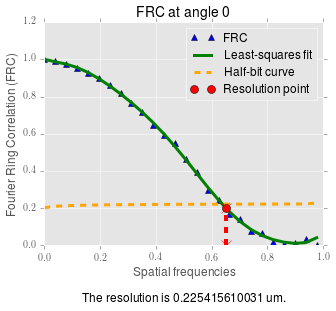

In [35]:
data = FourierCorrelationDataCollection()

image1, image2 = imops.checkerboard_split(image)

frc_task = frc.FRC(image1, image2, args.d_bin)
data[0] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
results = analyzer.execute()

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_one(0)

## Generate PSF

Based on the FRC measurement, a PSF is genrated with a simple Gaussian model, using the FRC resolution figure as the FWHM value.  

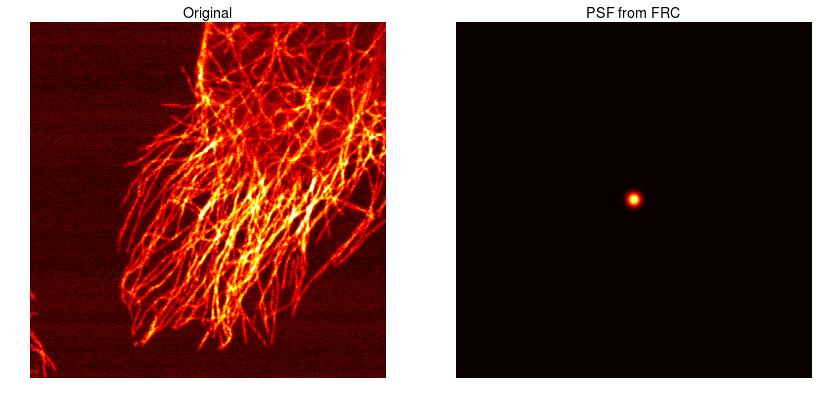

In [36]:
import supertomo.psf.psfgen as psfgen

fwhm = [results[0].resolution['resolution'],] * 2

psf_generator = psfgen.PsfFromFwhm(fwhm)

psf = psf_generator.xy()

showim.display_2d_images(imops.enhance_contrast(image_copy, percent_saturated=0.3), 
                         psf,
                         image1_title="Original",
                         image2_title="PSF from FRC"
                         
                    )

## Run deconvolution

Having generated the PSF, deconvolution is now run for 60 iterations. No stopping condition is used, because I wanted to evaluate the performance of the various parameters later on. For later FRC analysis, the intermediate results are saved on the disk.

In [37]:
from scipy.ndimage import gaussian_filter

#psf = Image(gaussian_filter(psf), psf.spacing)

writer = imwrap.TiffImageWriter(data_dir)

task = deconvolve.DeconvolutionRL(image, psf, writer, args)
task.execute()

The original image size is (512, 512)
The deconvolution will be run with 1 blocks
The internal block size is (512, 512)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/60                ] E/S/U/N=0/21624790/13640073/0, LEAK=-0.49662575981%, TAU1=0.0486611016095, TIME=0.196s, U/ESU=0.387 
Beginning the computation of the 1. estimate
[>                 2/60                ] ETA:10.4s E/S/U/N=0/27247482/8042292/0, LEAK=-0.567613012728%, TAU1=0.0329357236624, TIME=0.170s, U/ESU=0.228 
Beginning the computation of the 2. estimate
[=>                3/60                ] ETA:9.2s E/S/U/N=0/30282142/5009828/0, LEAK=-0.573873371454%, TAU1=0.0262066572905, TIME=0.138s, U/ESU=0.142 
Beginning the computation of the 3. estimate
[==>               4/60                ] ETA:9.0s E/S/U/N=72/31839773/3449465/0, LEAK=-0.566290585963%, TAU1=0.0222679432482, TIME=0.157s, U/ESU=9.77E-2 
Beginning the computation of the 4. estimate
[==>               5/60         

## Results

It is evident that 60 iterations are excessive, although the result is much improved from the one seen with the theoretical PSF. The algorithm clearly is able to focuse more on the details, rather than strongly amplifying the noise and trying to make the details smaller than they are.

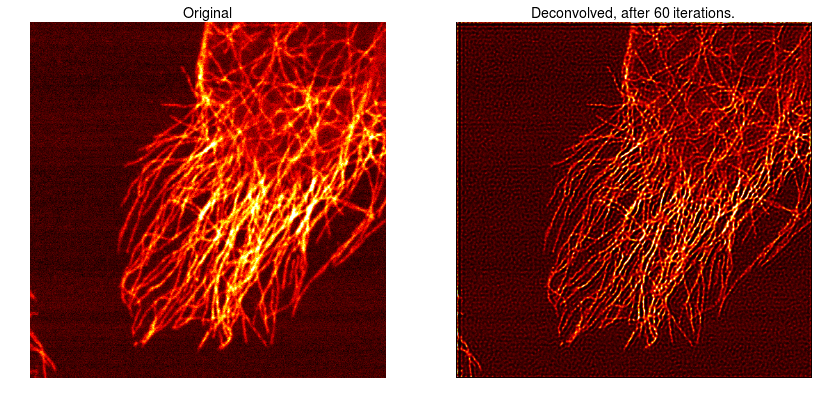

In [38]:
result = task.get_result()

showim.display_2d_images(imops.enhance_contrast(image, percent_saturated=0.3), 
                         imops.enhance_contrast(result, percent_saturated=0.3),
                         image1_title="Original",
                         image2_title="Deconvolved, after {} iterations.".format(n_iterations))




## FRC analysis of the deconvolution progress

Here I analyse each of the intermediate results from the deconvolution with FRC. The peak resolution value is achieved after 34 iterations, but already after 20, the improvement is at single-nanometer-scale, which means that it should be quite ok to stop the deconvolution there.

In [39]:

frc_data = FourierCorrelationDataCollection()


for idx in range(n_iterations):
    image_name = "result_{}.tif".format(idx)

    image_path = os.path.join(data_dir, image_name)

    image = read.get_image(image_path)
    image1, image2 = imops.checkerboard_split(image)
    
    frc_task = frc.FRC(image1, image2, args.d_bin)
    frc_data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(frc_data, spacing[0]*sqrt(2), args)
results = analyzer.execute()


Fit starts at 0.7421875
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7421875
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7421875
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7421875
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7421875
Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7421875
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7421875
Opti

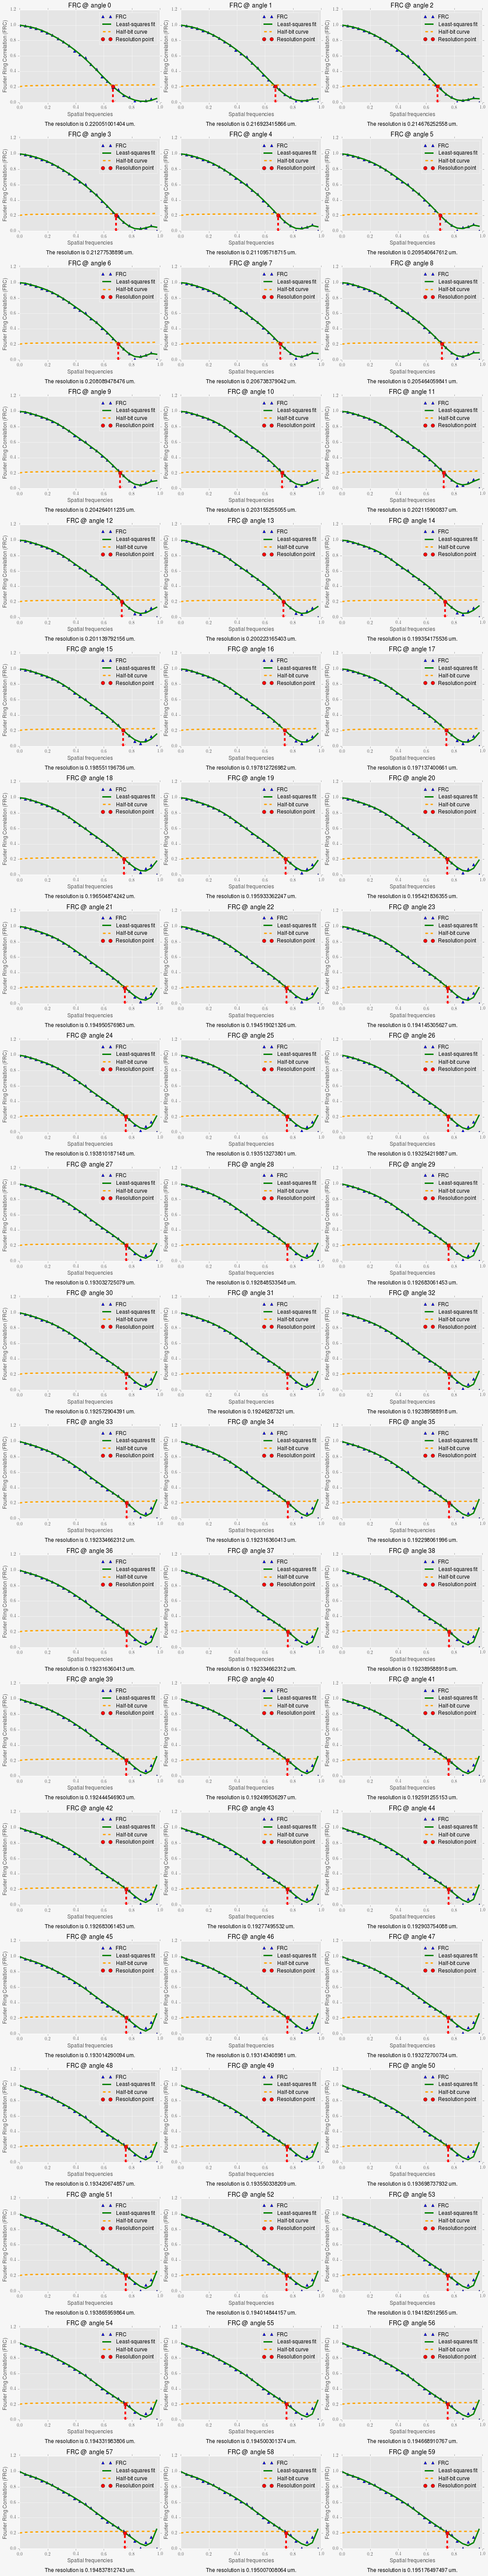

In [40]:

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

## Regarding the measured FRC values

I wanted to see look more closely into how the FRC values behave as a function of the iteration count. The *SuperTomo* deconvolution algorithm also calculates several parameter values that have traditionally been used to evaluate the progress of an iterative deconvolution. For more info, look at (Koho et al 2014). 

Here I normalize all the parameter values (0-1) for easy comparison and plotting. The original values are maintained in the *deconvolution_parameters* dataframe.

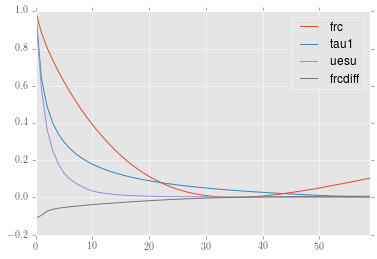

In [41]:
# Get a list of the resolution values as a function of iteration number
iterations = list()
resolutions = list()

for dataset in results:
    iterations.append(int(dataset[0]))
    resolutions.append(dataset[1].resolution["resolution"])

iterations, resolutions = zip(*sorted(zip(iterations, resolutions)))

# Get saved deconvolution parameters
deconvolution_parameters = task.progress_parameters
deconvolution_parameters['frc'] = resolutions


# Set up curves
curves = deconvolution_parameters.loc[:, ['frc', 'tau1', 'uesu']]

curves['frc'] -= curves['frc'].min()
curves['frc'] /= curves['frc'].max()

curves['tau1'] -= curves['tau1'].min()
curves['tau1'] /= curves['tau1'].max()

curves['uesu'] -= curves['uesu'].min()
curves['uesu'] /= curves['uesu'].max() 

curves['frcdiff'] = np.gradient(curves['frc'])



curves.plot()

## Regarding the FRC resolution curve

The FRC resolution value curve behaves in a very interesting way. It is first of all much more linear than *u_esu* and *tau1* and what is quite extraordinary,  the FRC value is able to discern the iteration after which the RL algorithm converges, and mainly starts amplifying the noise.

In [42]:
zero_crossing = np.where(np.diff(np.sign(curves['frcdiff'])))[0][0]

print "The deconvolution should be stopped at iteration {}.".format(zero_crossing)

The deconvolution should be stopped at iteration 34.


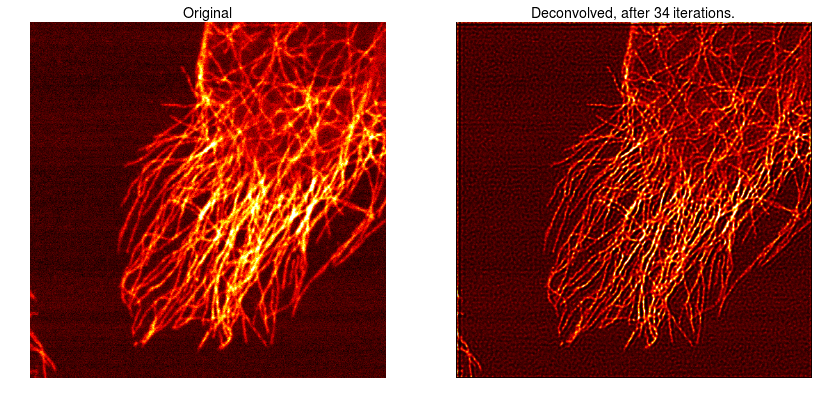

In [43]:
image_path = os.path.join(data_dir, "result_{}.tif".format(zero_crossing))

result_image = read.get_image(image_path)

showim.display_2d_images(imops.enhance_contrast(image_copy, percent_saturated=0.3), 
                         imops.enhance_contrast(result_image, percent_saturated=0.3),
                         image1_title="Original",
                         image2_title="Deconvolved, after {} iterations.".format(zero_crossing))



